In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, 
                                    Dropout, BatchNormalization, Input, 
                                    Activation, SpatialDropout2D, LayerNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
from collections import Counter

2025-05-04 16:21:28.184985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746375688.381584      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746375688.445218      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Configuration of some paramaters
IMG_SIZE = 224 # Define a reshape size (trying this for now)
BATCH_SIZE = 8  #high batch can cause bottleneck for cpu and gpu (low is slow too)
CLASSES = ['Normal','Pneumonia','Lung_Opacity']

In [3]:
#Loading and augmentation
def augment_image(image, label):
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.random_flip_left_right(image)
    return tf.clip_by_value(image, 0.0, 1.0), label
    
    return image, label

def build_tfdata_pipeline(data_dir, augment=False, batch_size=BATCH_SIZE, shuffle=False):
    ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='grayscale',
        batch_size=None,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle=shuffle,
        seed=42 if shuffle else None,
    )
    # Normalization (pixel divsion to 255 like first workshop)
    ds = ds.map(lambda x, y: (x/255.0, y), num_parallel_calls=tf.data.AUTOTUNE)
    # Apply augmentation 
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
        
    # Batch and optimize for memory performance 
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Create datasets
train_dataset = build_tfdata_pipeline(
    '/kaggle/input/pneumoniathreeclasses/Splitthree/train',
    augment=True, #only for training
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_dataset = build_tfdata_pipeline(
    '/kaggle/input/pneumoniathreeclasses/Splitthree/val',
    augment=False,
    batch_size=BATCH_SIZE,
    shuffle=False
).cache()
test_dataset = build_tfdata_pipeline(
    '/kaggle/input/pneumoniathreeclasses/Splitthree/test',
    augment=False,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 15492 files belonging to 3 classes.


I0000 00:00:1746375717.828612      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 3320 files belonging to 3 classes.
Found 3321 files belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


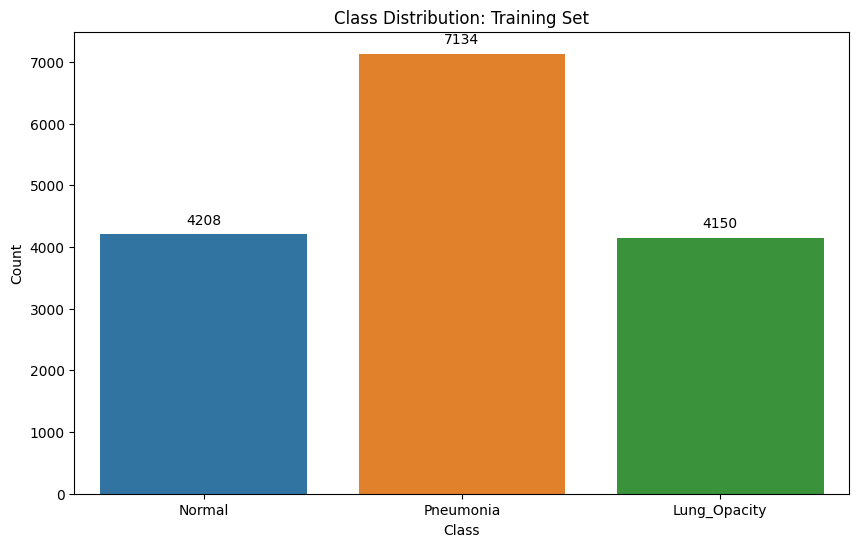

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


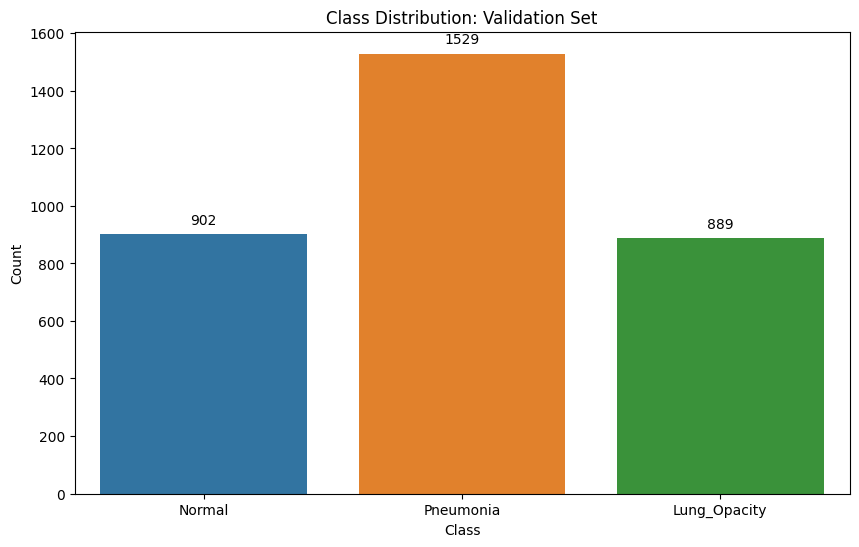

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


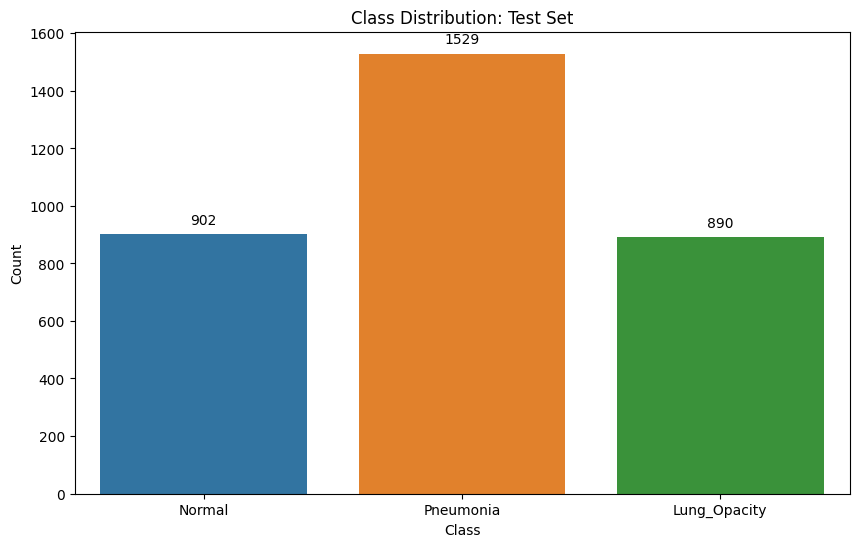

Training counts: {'Normal': 4208, 'Pneumonia': 7134, 'Lung_Opacity': 4150}
Validation counts: {'Normal': 902, 'Pneumonia': 1529, 'Lung_Opacity': 889}
Test counts: {'Normal': 902, 'Pneumonia': 1529, 'Lung_Opacity': 890}


In [4]:
#Visuals
def get_class_distribution(dataset, class_names):
    """Counts class distribution from a tf.data.Dataset"""
    counts = Counter()
    for _, labels in dataset.unbatch():
        class_idx = tf.argmax(labels).numpy()
        counts[class_idx] += 1
    
    # Convert to list in class order
    return [counts[i] for i in range(len(class_names))]

def plot_class_distribution(counts, class_names, title=""):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=class_names, y=counts)
    plt.title(f'Class Distribution: {title}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    
    # Add counts on top of bars
    for p in ax.patches:
        ax.annotate(f"{int(p.get_height())}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.show()
# Get distributions
train_counts = get_class_distribution(train_dataset, CLASSES)
val_counts = get_class_distribution(val_dataset, CLASSES)
test_counts = get_class_distribution(test_dataset, CLASSES)
# Visualize
plot_class_distribution(train_counts, CLASSES, "Training Set")
plot_class_distribution(val_counts, CLASSES, "Validation Set") 
plot_class_distribution(test_counts, CLASSES, "Test Set")
# Print exact counts
print(f"Training counts: {dict(zip(CLASSES, train_counts))}")
print(f"Validation counts: {dict(zip(CLASSES, val_counts))}")
print(f"Test counts: {dict(zip(CLASSES, test_counts))}")

Sample Augmented Training Images:


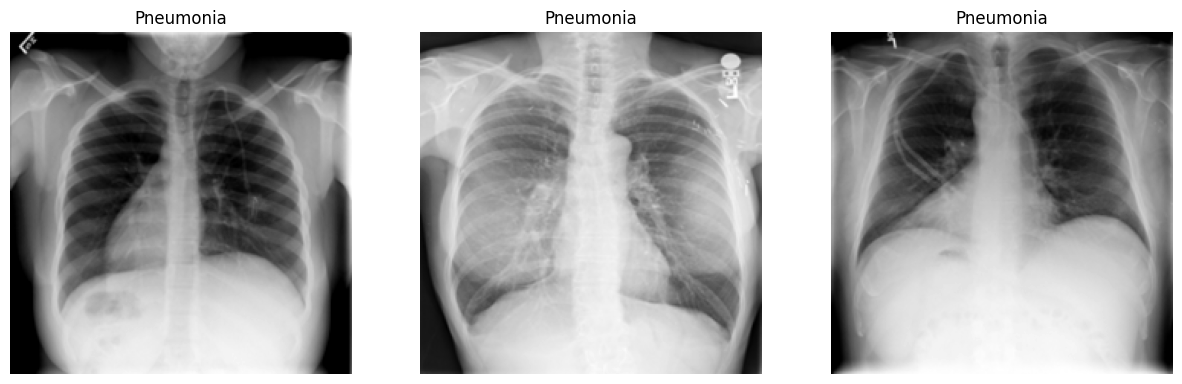

In [5]:
def show_augmented_images(dataset, num_images=3):
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):  # Take 1 batch
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i+1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(CLASSES[tf.argmax(labels[i])])
            plt.axis('off')
    plt.show()
    # Visualize augmented images
print("Sample Augmented Training Images:")
show_augmented_images(train_dataset, num_images=3)

In [6]:
def create_model():
    model = Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
      # First convolutional block
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    LayerNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Second convolutional block
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    LayerNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Third convolutional block
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    LayerNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Fourth convolutional block
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    LayerNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Flatten and fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    LayerNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    LayerNormalization(),
    Dropout(0.4),
    Dense(len(CLASSES), activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-4,clipvalue=1.0),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    return model
model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 224, 224, 32)        │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 112, 112, 64)        │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 56, 56, 128)         │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_3                │ (None, 28, 28, 256)         │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,192,931 (99.92 MB)

 Trainable params: 26,192,931 (99.92 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.arange(len(CLASSES)),
    y=np.repeat(np.arange(len(CLASSES)), train_counts)
)
class_weights = dict(enumerate(class_weights))

print("Class counts (Train):", dict(zip(CLASSES, train_counts)))
print("Class weights:", class_weights)

Class counts (Train): {'Normal': 4208, 'Pneumonia': 7134, 'Lung_Opacity': 4150}
Class weights: {0: 1.2271863117870723, 1: 0.7238575834034202, 2: 1.2443373493975904}


In [8]:
# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
     verbose=1,
    factor=0.2,
    min_lr=1e-5
)
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    'best_model3class.sci.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
#  Combine callbacks in a list
callbacks = [reduce_lr, model_checkpoint,early_stop]
# Training Parameters
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,  # Explicit validation data
    callbacks=callbacks,
    class_weight=class_weights,
)

Epoch 1/40


I0000 00:00:1746375781.568343      97 service.cc:148] XLA service 0x7a345c00fa60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746375781.568892      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746375782.345976      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


   6/1937 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - accuracy: 0.4236 - loss: 1.8406 - precision: 0.4299 - recall: 0.4236  

I0000 00:00:1746375791.787995      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1937/1937 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5769 - loss: 0.9452 - precision: 0.6025 - recall: 0.5413
Epoch 1: val_accuracy improved from -inf to 0.82831, saving model to best_model3class.sci.keras
1937/1937 ━━━━━━━━━━━━━━━━━━━━ 77s 31ms/step - accuracy: 0.5770 - loss: 0.9451 - precision: 0.6025 - recall: 0.5414 - val_accuracy: 0.8283 - val_loss: 0.4301 - val_precision: 0.8315 - val_recall: 0.8202 - learning_rate: 1.0000e-04
Epoch 2/40
1935/1937 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8251 - loss: 0.3970 - precision: 0.8300 - recall: 0.8190
Epoch 2: val_accuracy improved from 0.82831 to 0.90181, saving model to best_model3class.sci.keras
1937/1937 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - accuracy: 0.8251 - loss: 0.3970 - precision: 0.8300 - recall: 0.8190 - val_accuracy: 0.9018 - val_loss: 0.2368 - val_precision: 0.9026 - val_recall: 0.9015 - learning_rate: 1.0000e-04
Epoch 3/40
1935/1937 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8751 - loss: 0.2922 - precision: 

In [9]:
# Evaluation
from tensorflow.keras.models import load_model
model1 = load_model('/kaggle/working/best_model3class.sci.keras')
# Evaluate model
test_results = model1.evaluate(test_dataset)
print("\nTest Metrics:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.2%}")
print(f"Precision: {test_results[2]:.2%}")
print(f"Recall: {test_results[3]:.2%}")

416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9105 - loss: 0.2755 - precision: 0.9105 - recall: 0.9105

Test Metrics:
Loss: 0.1549
Accuracy: 94.85%
Precision: 94.85%
Recall: 94.85%


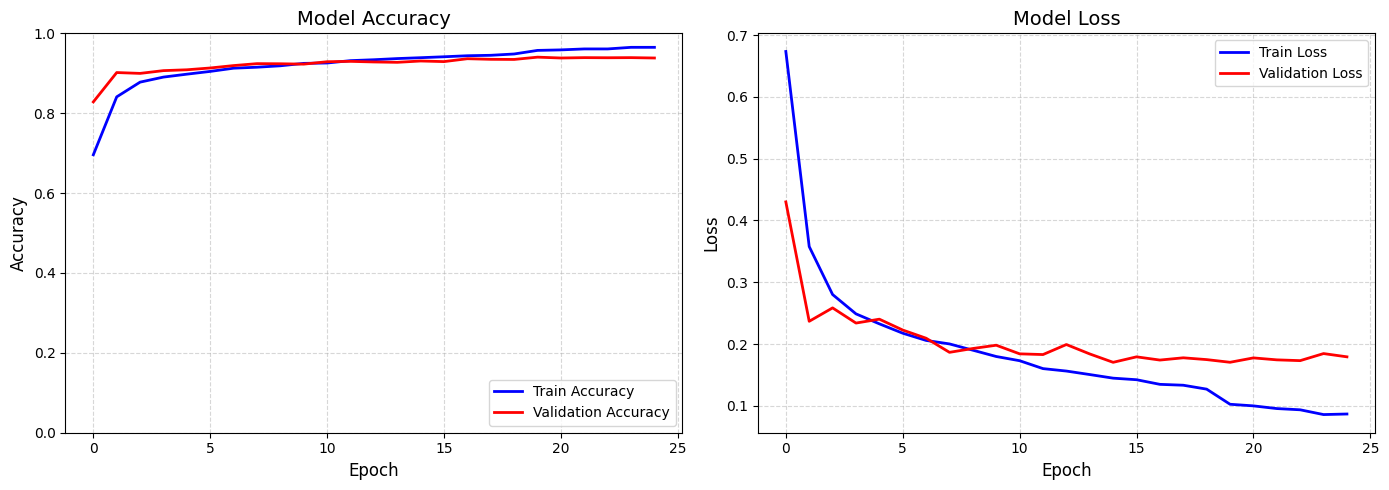

In [10]:
# Plot training history
plt.figure(figsize=(14, 5))

# 1. Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylim([0, 1])  # Set y-axis limits to 0-1 for clarity
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)

# 2. Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


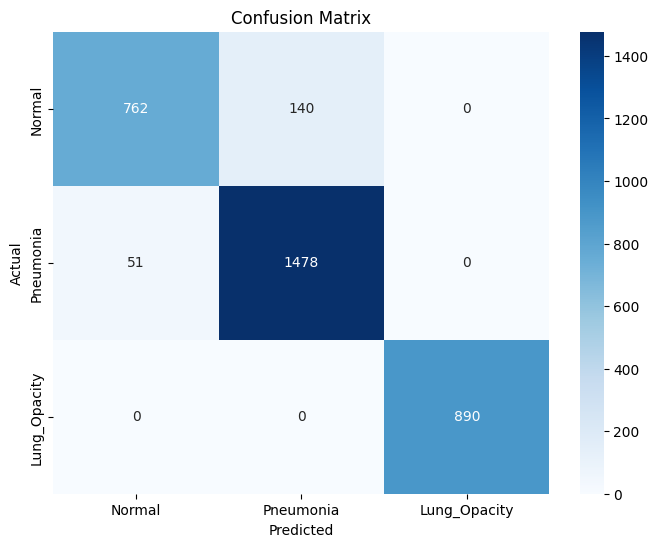

In [15]:
from sklearn.metrics import confusion_matrix
# Get predictions and true labels
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
# Print classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASSES))


Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.84      0.89       902
   Pneumonia       0.91      0.97      0.94      1529
Lung_Opacity       1.00      1.00      1.00       890

    accuracy                           0.94      3321
   macro avg       0.95      0.94      0.94      3321
weighted avg       0.94      0.94      0.94      3321



In [18]:
import shutil
import os
from IPython.display import FileLink

# 1. Compress the model file
shutil.make_archive('best_model', 'zip', '/kaggle/working', 'best_model3class.sci.keras')

# 2. Verify the file exists
if os.path.exists('/kaggle/working/best_model.zip'):
    print("ZIP created successfully!")
    
    # 3. Create download link
    display(FileLink('best_model.zip'))
else:
    print("Error: ZIP file not created. Check model path.")

ZIP created successfully!


/kaggle/working/best_model.zip

In [21]:
import pandas as pd

# Generate layer summary with shapes
def visualize_model_shapes(model):
    summary = []
    for layer in model.layers:
        summary.append([
            layer.name,
            layer.output.shape,
            layer.count_params(),
            layer.__class__.__name__
        ])
    return pd.DataFrame(summary, columns=['Layer', 'Output Shape', 'Params', 'Type'])

# Display as interactive table
layer_df = visualize_model_shapes(model)
layer_df.style.background_gradient(cmap='Blues')

,Layer,Output Shape,Params,Type
0,conv2d,"(None, 224, 224, 32)",320,Conv2D
1,conv2d_1,"(None, 224, 224, 32)",9248,Conv2D
2,layer_normalization,"(None, 224, 224, 32)",64,LayerNormalization
3,max_pooling2d,"(None, 112, 112, 32)",0,MaxPooling2D
4,dropout,"(None, 112, 112, 32)",0,Dropout
5,conv2d_2,"(None, 112, 112, 64)",18496,Conv2D
6,conv2d_3,"(None, 112, 112, 64)",36928,Conv2D
7,layer_normalization_1,"(None, 112, 112, 64)",128,LayerNormalization
8,max_pooling2d_1,"(None, 56, 56, 64)",0,MaxPooling2D
9,dropout_1,"(None, 56, 56, 64)",0,Dropout
